In [ ]:
!pip3 install pydot
!pip3 install pydotplus
!pip3 install graphviz
#brew install graphviz

### Adgard optimizer 쓰면 학습이 안됨

### Origin Code

In [ ]:
https://github.com/hexiangnan/neural_collaborative_filtering/blob/4aab159e81c44b062c091bdaed0ab54ac632371f/GMF.py#L83

### Dataset

In [1]:
# key : user, value : item list
user_map = {}
max_item_id = -1
with open('u.data') as f:
    lines = f.readlines()
    for line in lines:
        # user id | item id | rating | timestamp
        user_id, item_id, rating, timestamp = line[:-1].split('\t')
        
        user_id = int(user_id)
        item_id = int(item_id)
        
        if user_id not in user_map :
            user_map[user_id] = []
        user_map[user_id].append(item_id)
        
        max_item_id = max(max_item_id, item_id)
        
num_users = len(user_map)
num_items = max_item_id
print('num_users: {}, num_items: {}'.format(num_users, num_items))

num_users: 943, num_items: 1682


In [141]:
import random

X_user = []
X_item = []
y = []

for user_id in user_map :
    pos_items = user_map[user_id]
    pos_item_cnt = len(pos_items)
    for item_id in pos_items :
        X_user.append(user_id)
        X_item.append(item_id)
        y.append(1)
    neg_item_sample = [item_id for item_id in range(1, num_items + 1) if item_id not in pos_items]
    neg_items = random.sample(neg_item_sample, pos_item_cnt) # put same number of neg items with pos items
    #neg_items = random.sample(neg_item_sample, 4) # put fixed number of neg items with pos items
    for item_id in neg_items :
        X_user.append(user_id)
        X_item.append(item_id)
        y.append(0)

In [142]:
c = list(zip(X_user, X_item, y))

random.shuffle(c)

X_user, X_item, y = zip(*c)

data_len = len(X_user)

X_train_user = X_user[:int(data_len * 0.8)]
X_train_item =  X_item[:int(data_len * 0.8)]
y_train = y[:int(data_len * 0.8)]

X_test_user = X_user[int(data_len * 0.8):]
X_test_item = X_item[int(data_len * 0.8):]
y_test = y[int(data_len * 0.8):]

In [143]:
sum(y), len(y)

(100000, 200000)

### Model

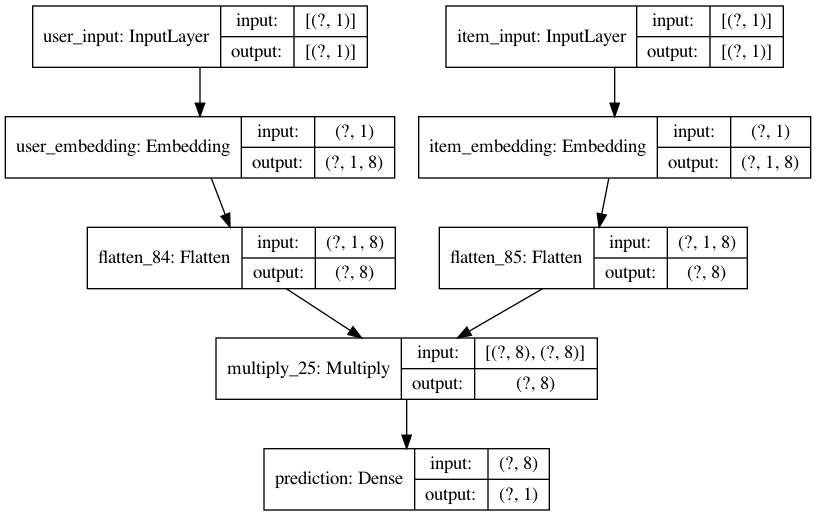

In [159]:
# python GMF.py --dataset ml-1m --epochs 20 --batch_size 256 --num_factors 8 --regs [0,0] --num_neg 4 --lr 0.001 --learner adam --verbose 1 --out 1
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

user_input_dim = num_users + 1
item_input_dim = num_items + 1

latent_dim = 8

'''
# user1 : item1, item2
# user2 : item1, item3
# user3 : item1, item4
# user4 : item1, item5
# user5 : item1, item2


# (2 pos / 2 neg) per user 
train_user_input = [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5]
train_item_input = [1, 2, 3, 4, 1, 3, 2, 5, 1, 4, 2, 5, 1, 5, 2, 3, 1, 2, 3, 4]
train_labels = [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]

print(len(train_user_input), len(train_item_input), len(train_labels))
'''

# Input variables
user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

MF_Embedding_User = tf.keras.layers.Embedding(input_dim = user_input_dim, output_dim = latent_dim, name = 'user_embedding',
                              embeddings_initializer='uniform', input_length=1)
MF_Embedding_Item = tf.keras.layers.Embedding(input_dim = item_input_dim, output_dim = latent_dim, name = 'item_embedding',
                              embeddings_initializer='uniform', input_length=1)   

# Crucial to flatten an embedding vector!
user_latent = tf.keras.layers.Flatten()(MF_Embedding_User(user_input))
item_latent = tf.keras.layers.Flatten()(MF_Embedding_Item(item_input))

# Element-wise product of user and item embeddings 
predict_vector = tf.keras.layers.Multiply()([user_latent, item_latent])

# Final prediction layer
prediction = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.LecunUniform(), name='prediction')(predict_vector)

model = tf.keras.Model(inputs=[user_input, item_input], outputs=prediction)

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [160]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

hist = model.fit([np.array(X_train_user), np.array(X_train_item)], #input
                 np.array(y_train), # labels 
                 batch_size=256, epochs=20, verbose=1, shuffle=True)


Epoch 1/20
625/625 [==============================] - 1s 1ms/step - loss: 0.5262 - precision_34: 0.7055 - recall_2: 0.7638
Epoch 2/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3909 - precision_34: 0.8148 - recall_2: 0.8393
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3534 - precision_34: 0.8333 - recall_2: 0.8577
Epoch 4/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3335 - precision_34: 0.8421 - recall_2: 0.8664A: 0s - loss: 0.3224 - precision_34: 0.8478 - recall
Epoch 5/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3214 - precision_34: 0.8473 - recall_2: 0.8720
Epoch 6/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3132 - precision_34: 0.8513 - recall_2: 0.8776
Epoch 7/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3068 - precision_34: 0.8546 - recall_2: 0.8796
Epoch 8/20
625/625 [==============================] - 1s 947us/step - loss: 0.3023 - pr

In [162]:
print("Evaluate on test data")
results = model.evaluate([np.array(X_test_user), np.array(X_test_item)], #input
                 np.array(y_test))
print("test loss, precision, recall :", results)

Evaluate on test data
1250/1250 [==============================] - 1s 745us/step - loss: 0.4420 - precision_34: 0.8119 - recall_2: 0.8454
test loss, precision, recall: [0.4420029819011688, 0.8118950128555298, 0.8454440832138062]


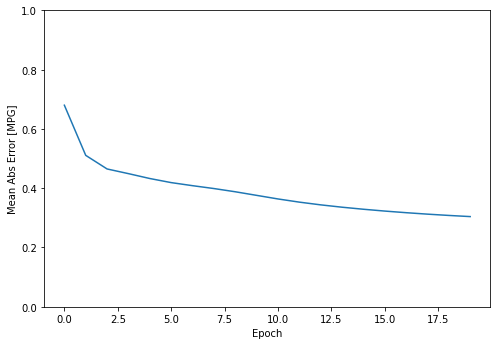

In [146]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.ylim([0,1])
  plt.show()

plot_history(hist)

### MLP

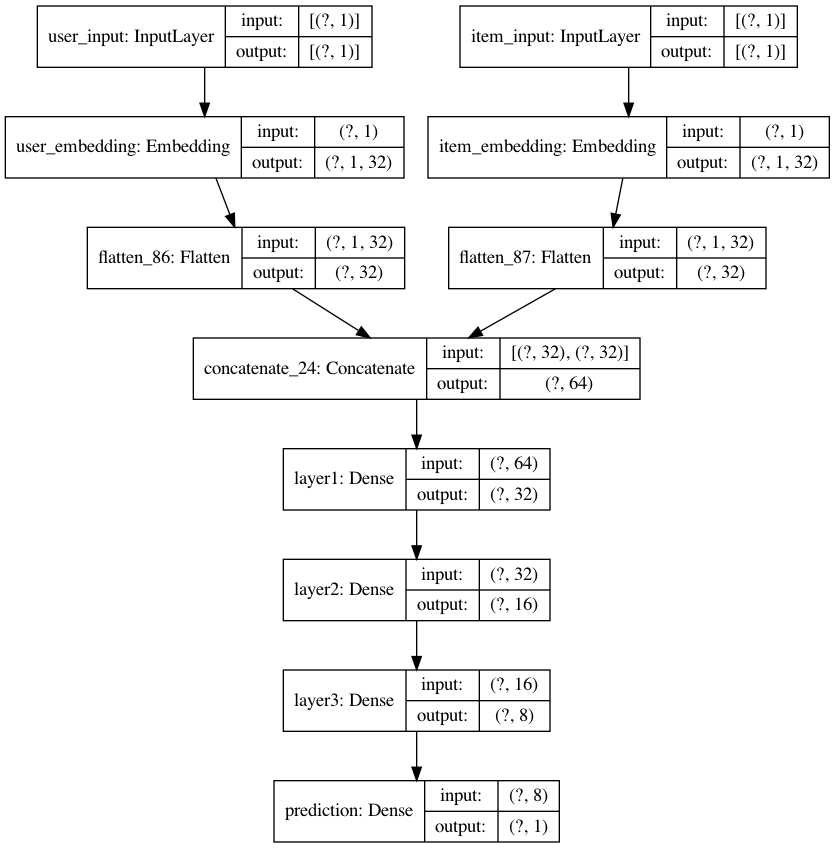

In [163]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

user_input_dim = num_users + 1
item_input_dim = num_items + 1

layers = [64,32,16,8]
num_layer = len(layers)

user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

MLP_Embedding_User = Embedding(input_dim = user_input_dim, output_dim = int(layers[0]/2), name = 'user_embedding',
                              embeddings_initializer='uniform', input_length=1)
MLP_Embedding_Item = Embedding(input_dim = item_input_dim, output_dim = int(layers[0]/2), name = 'item_embedding',
                              embeddings_initializer='uniform', input_length=1)

# Crucial to flatten an embedding vector!
user_latent = Flatten()(MLP_Embedding_User(user_input))
item_latent = Flatten()(MLP_Embedding_Item(item_input))

# The 0-th layer is the concatenation of embedding layers
vector = tf.keras.layers.Concatenate()([user_latent, item_latent])

# MLP layers
for idx in range(1, num_layer):
    layer = Dense(layers[idx], activation='relu', name = 'layer%d' %idx)
    vector = layer(vector)

# Final prediction layer
prediction = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.LecunUniform(), name='prediction')(vector)


model = Model(inputs=[user_input, item_input], outputs=prediction)

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [164]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

hist = model.fit([np.array(X_train_user), np.array(X_train_item)], #input
                 np.array(y_train), # labels 
                 batch_size=256, epochs=20, verbose=1, shuffle=True)

Epoch 1/20
625/625 [==============================] - 1s 2ms/step - loss: 0.4982 - precision_35: 0.7394 - recall_3: 0.7880
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 0.4699 - precision_35: 0.7525 - recall_3: 0.8043
Epoch 3/20
625/625 [==============================] - 1s 1ms/step - loss: 0.4472 - precision_35: 0.7654 - recall_3: 0.8229
Epoch 4/20
625/625 [==============================] - 1s 1ms/step - loss: 0.4155 - precision_35: 0.7818 - recall_3: 0.8452
Epoch 5/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3981 - precision_35: 0.7909 - recall_3: 0.8530
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3835 - precision_35: 0.7981 - recall_3: 0.8617
Epoch 7/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3659 - precision_35: 0.8057 - recall_3: 0.8725A: 0s - loss: 0.3611 - precision_35: 0.8081 - recall_
Epoch 8/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3497 - pre

In [165]:
print("Evaluate on test data")
results = model.evaluate([np.array(X_test_user), np.array(X_test_item)], #input
                 np.array(y_test))
print("test loss, precision, recall :", results)

Evaluate on test data
1250/1250 [==============================] - 1s 815us/step - loss: 0.5538 - precision_35: 0.7919 - recall_3: 0.8492
test loss, precision, recall : [0.5537692904472351, 0.7918634414672852, 0.8492051362991333]


### NCF

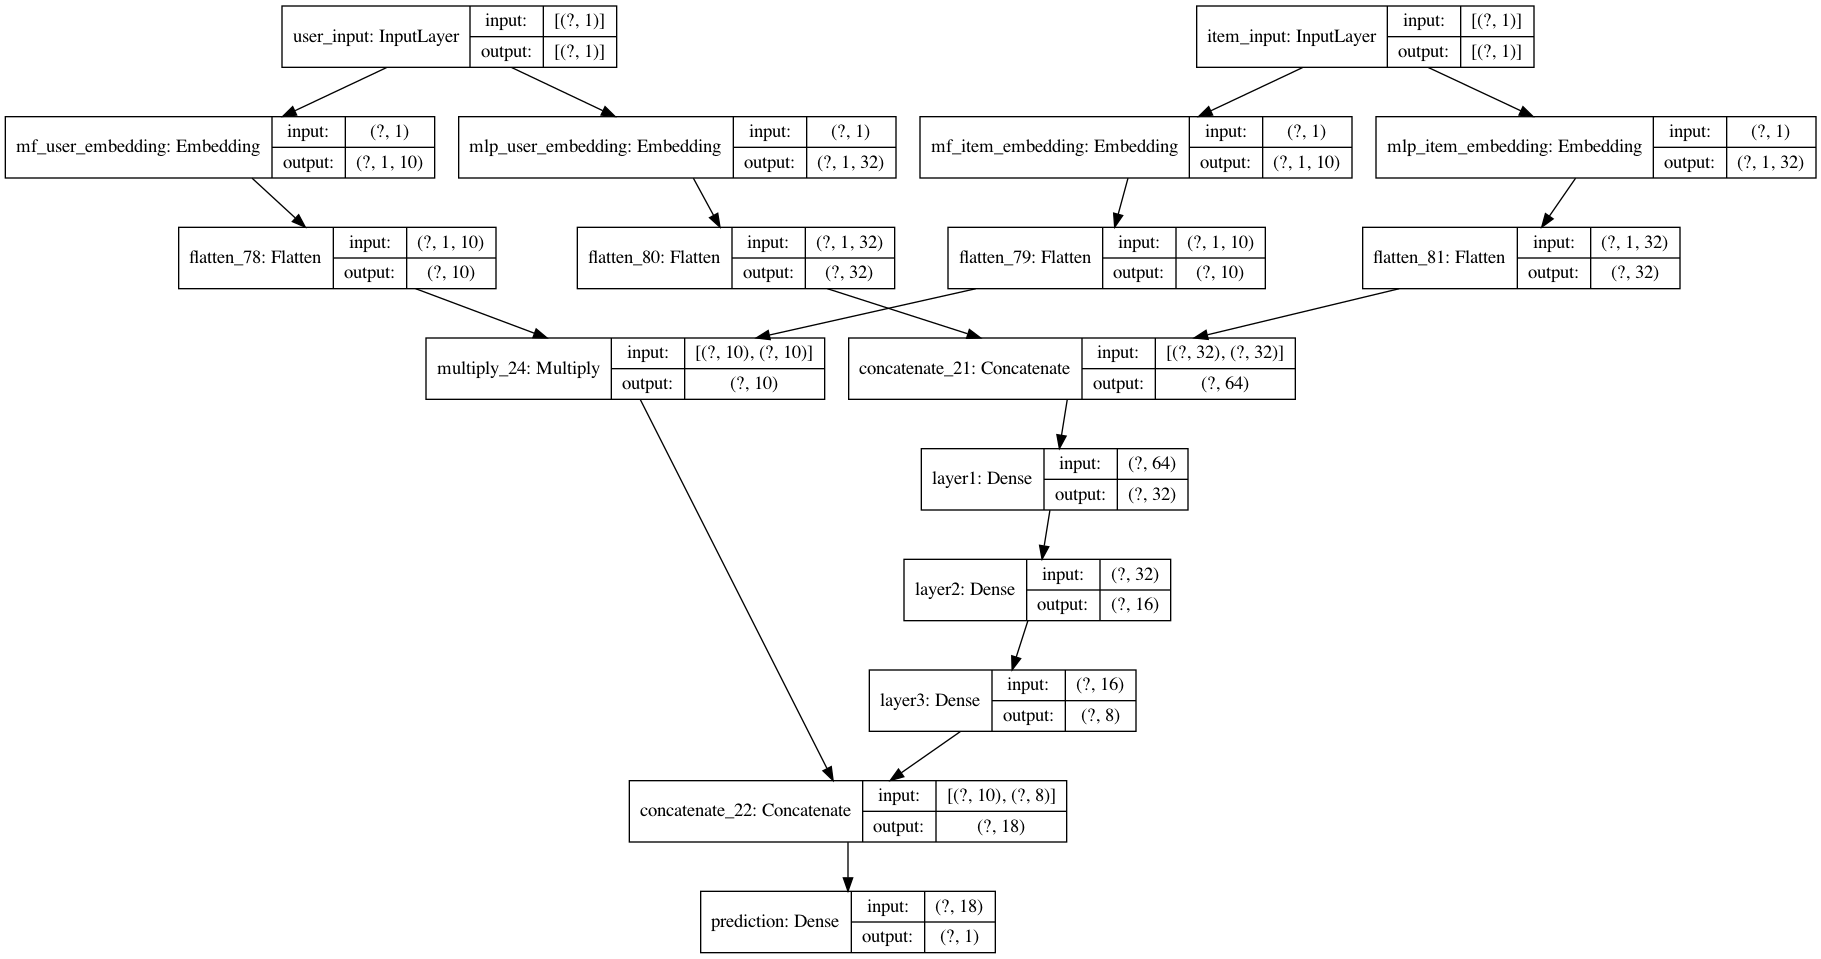

In [152]:
# python NeuMF.py --dataset ml-1m --epochs 20 --batch_size 256 --num_factors 8 --layers [64,32,16,8] --reg_mf 0 --reg_layers [0,0,0,0] --num_neg 4 --lr 0.001 --learner adam --verbose 1 --out 1
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

layers = [64, 32, 16, 8]
mf_dim=10
num_layer = len(layers) #Number of layers in the MLP

user_input_dim = num_users + 1
item_input_dim = num_items + 1

# Input variables
user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

# Embedding layer
MF_Embedding_User = Embedding(input_dim = user_input_dim, output_dim = mf_dim, name = 'mf_user_embedding',
                              embeddings_initializer='uniform', input_length=1)
MF_Embedding_Item = Embedding(input_dim = item_input_dim, output_dim = mf_dim, name = 'mf_item_embedding',
                              embeddings_initializer='uniform', input_length=1)   

MLP_Embedding_User = Embedding(input_dim = user_input_dim, output_dim = int(layers[0]/2), name = 'mlp_user_embedding',
                              embeddings_initializer='uniform', input_length=1)
MLP_Embedding_Item = Embedding(input_dim = item_input_dim, output_dim = int(layers[0]/2), name = 'mlp_item_embedding',
                              embeddings_initializer='uniform', input_length=1)   

# MF part
mf_user_latent = Flatten()(MF_Embedding_User(user_input))
mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
mf_vector = tf.keras.layers.Multiply()([mf_user_latent, mf_item_latent])

# MLP part 
mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
mlp_vector = tf.keras.layers.Concatenate()([mlp_user_latent, mlp_item_latent])
for idx in range(1, num_layer):
    layer = Dense(layers[idx], activation='relu', name = 'layer%d' %idx)
    mlp_vector = layer(mlp_vector)

# Concatenate MF and MLP parts
predict_vector = tf.keras.layers.Concatenate()([mf_vector, mlp_vector])

# Final prediction layer
prediction = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.LecunUniform(), name='prediction')(predict_vector)

model = Model(inputs=[user_input, item_input], 
              outputs=prediction)

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [156]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

hist = model.fit([np.array(X_train_user), np.array(X_train_item)], #input
                 np.array(y_train), # labels 
                 batch_size=256, epochs=20, verbose=1, shuffle=True)

Epoch 1/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1500 - precision_32: 0.9302 - recall: 0.9481
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1374 - precision_32: 0.9362 - recall: 0.9528
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1341 - precision_32: 0.9384 - recall: 0.9542
Epoch 4/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1281 - precision_32: 0.9418 - recall: 0.9558
Epoch 5/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1256 - precision_32: 0.9424 - recall: 0.9570A: 0s - loss: 0.1056 - precision_32: 0.9518 
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1195 - precision_32: 0.9465 - recall: 0.9586
Epoch 7/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1157 - precision_32: 0.9476 - recall: 0.9604
Epoch 8/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1127 - precision_32: 0.9493 - rec

In [154]:
print("Evaluate on test data")
results = model.evaluate([np.array(X_test_user), np.array(X_test_item)], #input
                 np.array(y_test))
print("test loss, test acc:", results)

Evaluate on test data
1250/1250 [==============================] - 1s 804us/step - loss: 0.7543 - precision_31: 0.7975
test loss, test acc: [0.7543385028839111, 0.7975497245788574]


### top-k

In [155]:
user = np.array([196 for i in range(item_input_dim - 1)])
item = np.array([i for i in range(1, item_input_dim)])

pred = model.predict([user, item])

list_ = [t for t in zip(item, pred.reshape(-1))]
sorted(list_, key=lambda x : x[1], reverse=True)

[(234, 0.9999862),
 (303, 0.999848),
 (116, 0.9998361),
 (50, 0.99972594),
 (13, 0.9997257),
 (324, 0.9996502),
 (466, 0.99934524),
 (100, 0.9993117),
 (294, 0.9992622),
 (272, 0.9992492),
 (302, 0.9990939),
 (269, 0.9987025),
 (129, 0.99868584),
 (742, 0.99861807),
 (443, 0.99847955),
 (1007, 0.9984626),
 (124, 0.9984067),
 (319, 0.9983454),
 (53, 0.9983097),
 (244, 0.9981841),
 (181, 0.9981483),
 (919, 0.99809253),
 (308, 0.99777955),
 (435, 0.99775994),
 (1099, 0.9976889),
 (180, 0.9976112),
 (127, 0.9974557),
 (286, 0.99729943),
 (66, 0.9972712),
 (258, 0.9967593),
 (70, 0.9967377),
 (268, 0.9962882),
 (307, 0.9958385),
 (709, 0.99558514),
 (262, 0.9954639),
 (242, 0.9954122),
 (452, 0.9950984),
 (88, 0.99441683),
 (185, 0.99422574),
 (245, 0.9938922),
 (36, 0.9938452),
 (214, 0.9937662),
 (381, 0.993597),
 (322, 0.9932231),
 (1316, 0.99320745),
 (372, 0.9927067),
 (25, 0.992664),
 (433, 0.992632),
 (231, 0.9925542),
 (42, 0.9922024),
 (204, 0.9921627),
 (773, 0.9916458),
 (684, 0.

In [140]:
for user, item, label in zip(X_test_user, X_test_item, y_test) :
    print(user, item, label)


886 655 1
851 160 1
184 602 1
455 213 1
590 127 1
703 147 1
733 244 1
509 260 1
401 507 1
87 477 1
877 274 1
308 1065 1
83 751 1
533 135 1
405 1579 1
18 482 1
401 1271 0
806 511 1
650 56 1
429 633 1
878 9 1
499 207 1
575 483 1
301 443 1
916 741 1
185 199 1
774 453 1
924 429 1
643 276 1
682 179 1
532 242 1
38 226 1
405 702 1
455 582 1
642 141 1
788 591 1
145 120 1
497 590 1
726 257 1
660 527 1
695 305 1
456 421 1
339 347 1
608 673 1
846 796 1
675 244 1
458 282 1
933 62 1
916 239 1
505 183 1
254 967 1
704 173 1
774 428 1
232 921 1
537 85 1
207 171 1
677 129 1
625 70 1
450 790 1
244 790 1
465 281 1
615 678 1
555 269 1
795 202 1
276 1273 1
268 479 1
627 956 1
5 398 1
453 125 1
548 431 1
232 294 1
313 208 1
671 431 1
200 280 1
621 174 1
271 174 1
411 117 1
880 120 1
201 100 1
164 300 1
55 1465 0
653 546 1
442 144 1
405 656 1
365 108 1
102 239 1
292 9 1
207 248 1
806 79 1
486 20 1
303 484 1
92 679 1
757 431 1
653 742 1
551 3 1
795 655 1
250 294 1
532 100 1
506 1608 1
194 157 1
927 143 1
181 

291 204 1
242 934 1
666 649 1
934 257 1
283 435 1
533 64 1
145 230 1
387 731 1
85 229 1
361 55 1
679 56 1
141 235 1
256 406 1
807 402 1
463 1383 1
405 168 1
429 921 1
606 404 1
901 732 1
374 526 1
465 175 1
893 471 1
94 90 1
317 271 1
311 570 1
665 496 1
68 763 1
936 1323 1
256 50 1
267 410 1
932 170 1
643 515 1
470 7 1
885 451 1
749 736 1
438 21 1
184 66 1
437 47 1
871 904 1
237 83 1
579 520 1
672 275 1
442 436 1
358 1046 0
293 416 1
222 750 1
9 402 1
643 721 1
459 289 1
479 153 1
935 118 1
49 590 1
586 288 1
160 952 1
537 129 1
269 821 1
862 151 1
881 1089 1
21 984 1
658 24 1
449 1011 1
535 515 1
846 559 1
830 431 1
379 7 1
894 923 1
328 620 1
237 187 1
421 1393 0
854 188 1
279 236 1
94 1032 1
840 210 1
606 127 1
676 172 1
708 125 1
660 316 1
536 419 1
143 682 1
642 769 1
846 294 1
870 421 1
416 302 1
361 166 1
569 258 1
833 56 1
440 243 1
605 293 1
896 198 1
6 321 1
201 221 1
56 29 1
291 619 1
548 1244 1
62 503 0
49 301 1
406 732 1
343 87 1
322 23 1
370 321 1
312 89 1
94 101 1
880 3

521 73 1
525 1014 1
407 448 1
163 288 1
219 433 1
374 98 1
313 1470 1
458 117 1
299 513 1
899 463 1
194 230 1
759 300 1
334 525 1
496 1401 1
16 302 1
497 797 1
188 13 1
80 208 1
334 1016 1
933 200 1
402 135 1
782 325 1
305 382 1
363 95 1
412 81 1
782 1089 1
827 258 1
268 831 1
399 8 1
826 127 1
102 720 1
20 181 1
405 374 1
406 96 1
682 572 1
796 237 1
454 423 1
942 945 1
41 357 1
59 380 1
116 269 1
393 338 1
95 422 1
889 642 1
592 188 1
907 198 1
634 137 1
1 138 1
905 322 1
314 1267 1
222 678 1
197 570 1
749 755 1
435 290 1
345 1008 1
627 282 1
18 204 1
892 175 1
896 302 1
219 269 1
504 1110 1
763 144 1
62 664 1
311 661 1
942 705 1
11 300 1
321 531 1
569 273 1
412 173 1
92 993 1
102 559 1
407 151 1
487 183 1
380 238 1
405 442 1
694 211 1
72 655 1
347 268 1
658 467 1
751 367 1
357 117 1
253 699 1
620 145 1
62 96 1
409 518 1
288 15 1
505 151 1
654 121 1
537 661 1
201 1245 1
232 705 1
300 872 1
214 93 1
918 132 1
258 333 1
833 135 1
757 1090 1
72 603 1
851 553 1
99 310 1
495 674 1
784 327

87 73 1
846 415 1
826 260 1
727 232 1
327 271 1
378 98 1
588 202 1
497 91 1
543 562 1
354 52 1
716 180 1
425 841 1
99 64 1
260 326 1
405 1565 1
330 559 1
535 447 1
887 1013 1
446 288 1
852 127 1
184 504 1
748 195 1
174 843 1
311 785 1
246 368 1
601 176 1
314 756 1
467 1011 1
450 662 1
786 724 1
472 68 1
328 566 1
114 157 1
933 67 1
880 783 1
470 1 1
194 98 1
301 161 1
569 125 1
600 2 1
773 288 1
592 482 1
223 322 1
889 919 1
417 343 1
620 924 1
828 70 1
471 465 1
511 322 1
385 1007 1
521 23 1
222 294 1
223 1014 1
514 222 1
374 554 1
1 148 1
90 317 1
901 429 1
854 925 1
234 97 1
385 629 1
485 346 1
648 676 1
38 303 0
650 654 1
255 288 1
747 94 1
297 213 1
682 186 1
508 223 1
373 70 1
64 288 1
537 972 1
561 163 1
38 916 1
141 249 1
501 125 1
420 690 1
344 86 1
700 73 1
769 222 1
747 26 1
605 276 1
14 202 1
936 150 0
643 53 1
91 504 1
497 526 1
185 181 1
464 307 1
506 200 1
279 73 1
338 654 1
712 462 1
409 89 1
653 510 1
885 172 1
843 651 1
871 22 1
393 1355 0
257 166 1
503 356 1
13 757 1

314 150 1
727 434 1
489 332 1
302 309 1
591 47 1
429 967 1
664 45 1
555 236 1
901 623 1
311 729 1
92 328 1
130 1089 1
321 48 1
320 148 1
825 294 1
530 174 1
714 472 1
514 747 1
501 293 1
201 1098 1
805 346 1
203 323 1
758 384 1
290 216 1
749 1274 1
406 73 1
8 187 1
605 831 1
919 527 1
48 308 1
295 386 1
194 515 1
638 430 1
258 323 1
916 111 1
466 909 1
495 576 1
60 507 1
833 452 1
99 963 1
399 959 1
868 452 1
187 134 1
886 87 1
70 69 1
280 540 1
806 258 1
151 486 1
711 169 1
60 671 1
807 139 1
545 121 1
916 160 1
313 525 1
44 474 1
318 162 1
907 98 1
65 514 1
234 634 1
487 672 1
127 243 1
889 129 1
893 412 1
726 294 1
116 20 1
846 234 1
10 505 1
616 303 1
586 238 1
854 274 1
244 566 1
788 504 1
455 135 1
478 222 1
13 97 1
435 742 1
234 1048 1
392 615 1
591 1023 0
466 326 1
410 300 1
405 1479 1
181 980 1
406 491 1
880 394 1
346 68 1
489 358 1
397 56 1
595 676 1
325 656 1
407 40 1
109 294 1
463 1244 1
202 423 1
882 369 1
255 322 1
846 638 1
642 1146 1
833 679 1
551 1135 1
813 892 1
204 8

557 262 1
702 228 1
804 231 1
878 451 1
826 265 1
249 255 1
537 290 1
543 190 1
512 183 1
671 288 1
54 475 1
868 746 1
687 321 1
796 367 1
94 258 1
852 257 1
459 333 1
506 226 1
882 183 1
551 203 1
2 111 1
563 153 1
96 98 1
733 1009 1
399 1041 0
499 605 1
225 193 1
507 678 1
421 674 1
293 213 1
69 123 1
815 135 1
257 129 1
655 762 1
214 318 1
194 125 1
276 214 1
872 1047 1
642 139 1
108 1272 0
299 662 1
826 391 1
214 960 1
538 956 1
164 245 1
654 222 1
664 1109 1
614 122 1
123 487 1
433 333 1
271 244 1
343 155 1
422 370 1
624 286 1
62 568 1
795 1095 1
642 1522 0
814 635 1
648 68 1
135 54 1
415 136 1
878 111 1
892 1035 1
592 216 1
922 258 1
237 9 1
506 204 1
815 54 1
295 465 1
456 603 1
276 231 1
943 546 1
533 566 1
405 570 1
943 625 1
22 407 1
290 183 1
359 295 1
13 24 1
466 550 1
838 181 1
393 783 1
796 980 0
894 280 1
823 404 1
706 117 1
586 496 1
244 154 1
243 514 1
780 199 1
235 85 1
664 54 1
110 184 1
92 265 1
659 43 1
650 21 1
488 304 1
507 271 1
524 676 1
795 768 1
704 1299 1
86

90 523 1
13 597 1
92 568 1
457 31 1
773 234 1
462 330 1
823 517 1
647 300 1
201 1006 1
450 80 1
708 271 1
425 448 1
268 407 1
885 208 1
41 180 1
560 1265 1
537 45 1
210 200 1
233 623 1
472 210 1
479 190 1
623 603 1
208 204 1
900 508 1
666 525 1
313 153 1
664 7 1
261 359 1
569 321 1
655 1578 1
320 240 1
293 628 1
322 1197 0
379 238 1
154 484 1
70 1035 1
454 210 1
162 685 1
264 447 1
834 342 1
241 302 1
943 72 1
795 381 1
753 71 1
325 1003 1
514 208 1
638 450 1
872 313 1
648 294 1
757 358 1
437 42 1
671 2 1
747 194 1
267 324 1
716 176 1
345 181 1
727 1215 1
239 531 1
494 238 1
654 283 1
716 318 1
328 273 1
293 124 1
207 566 1
157 407 1
70 1 1
497 123 1
489 1265 1
479 148 1
408 258 1
457 658 1
454 202 1
880 1181 1
643 89 1
222 642 1
825 289 1
625 654 1
916 3 1
884 275 1
239 589 1
22 216 1
159 333 1
90 60 1
887 763 1
746 132 1
735 245 1
409 203 1
21 148 1
621 783 1
749 526 1
417 1550 1
301 566 1
25 131 1
261 259 1
464 292 1
167 735 1
266 313 1
238 756 1
551 710 1
495 155 1
388 117 1
886 13

450 415 1
214 257 1
290 318 1
71 1453 0
567 612 1
618 197 1
804 219 1
850 663 1
157 286 1
201 1224 1
883 10 1
763 196 1
507 306 1
249 173 1
936 1226 1
664 664 1
360 174 1
291 3 1
468 469 1
407 182 1
393 145 1
291 244 1
907 744 1
320 51 1
634 405 1
924 705 1
823 475 1
429 188 1
401 11 1
354 1241 1
201 204 1
504 499 1
207 92 1
394 62 1
344 246 1
465 474 1
890 121 1
650 510 1
452 1410 1
239 209 1
374 11 1
843 690 1
416 32 1
102 188 1
583 1178 0
773 218 1
669 208 1
7 588 1
57 194 1
666 663 1
527 466 1
385 1456 1
456 127 1
345 255 1
588 365 1
653 386 1
108 405 1
671 546 1
478 840 0
748 228 1
708 21 1
778 423 1
6 539 1
655 945 1
893 849 1
903 684 1
345 278 1
92 148 1
497 13 1
267 28 1
791 302 1
690 790 1
496 1091 1
399 420 1
429 163 1
654 385 1
115 83 1
671 257 1
340 526 1
184 515 1
912 64 1
469 215 1
379 381 1
195 877 1
185 514 1
72 2 1
222 399 1
919 305 1
478 196 1
779 7 1
532 348 1
264 56 1
447 218 1
745 28 1
798 202 1
393 852 0
291 563 1
854 87 1
833 379 1
334 135 1
43 277 1
378 410 1
39

49 477 1
708 873 1
644 246 0
27 288 1
259 1032 0
408 294 1
178 465 1
523 50 1
758 520 1
790 559 1
606 255 1
851 127 1
8 568 1
425 515 1
564 245 1
393 538 1
749 930 1
938 248 1
222 239 1
387 642 1
43 747 1
387 659 1
450 275 1
886 144 1
313 576 1
373 96 1
567 608 1
708 535 1
721 873 1
189 815 1
415 641 1
31 124 1
452 490 1
833 980 1
874 111 1
130 321 1
7 215 1
857 321 1
151 125 1
311 1 1
75 473 1
221 282 1
738 50 1
932 1035 1
268 395 1
299 645 1
128 507 1
738 141 1
902 993 1
406 1202 1
112 887 1
871 335 1
137 1450 0
476 300 1
416 1160 1
425 452 1
130 678 1
296 815 1
405 727 1
254 229 1
506 1580 0
224 470 1
782 259 1
214 154 1
712 946 1
305 357 1
234 462 1
754 819 1
501 508 1
916 106 1
653 227 1
523 197 1
301 686 1
793 597 1
59 845 1
731 1503 1
632 1028 1
405 639 1
805 748 1
58 1569 0
618 485 1
152 234 1
619 562 1
62 257 1
752 345 1
392 59 1
318 24 1
258 243 1
387 650 1
716 283 1
524 521 1
312 10 1
932 530 1
655 1284 1
393 1058 1
195 1413 1
634 273 1
221 399 1
279 586 1
592 939 1
864 176 

314 144 1
628 690 1
474 582 1
19 382 1
757 98 1
886 919 1
805 679 1
378 597 1
561 241 1
343 582 1
927 138 1
262 845 1
313 50 1
280 232 1
655 685 1
393 763 1
935 313 1
723 191 1
593 405 1
721 135 1
723 748 1
339 474 1
748 118 1
290 930 1
553 1124 1
318 94 1
561 645 1
882 70 1
738 449 1
804 415 1
312 507 1
788 64 1
269 170 1
201 76 1
369 196 1
336 577 1
600 391 1
293 1161 1
59 133 1
268 223 1
821 473 1
556 134 1
109 1210 1
87 321 1
670 519 1
639 923 1
932 203 1
168 411 1
399 73 1
267 7 1
210 210 1
378 202 1
255 118 1
435 155 1
328 281 1
389 494 1
848 443 1
328 504 1
907 710 1
830 648 1
450 228 1
13 14 1
534 986 1
393 51 1
198 187 1
712 944 1
455 591 1
6 56 1
76 513 1
533 380 1
506 195 1
399 2 1
132 124 1
407 455 1
479 200 1
787 880 1
537 713 1
334 236 1
180 729 1
915 310 1
119 511 1
936 1344 1
940 529 1
371 73 1
102 322 1
463 235 1
743 322 1
402 275 1
919 681 1
315 645 1
577 4 1
385 93 1
401 584 1
212 527 1
387 737 1
85 272 1
276 928 1
710 172 1
409 98 1
321 205 1
838 311 1
658 100 1
263

642 443 1
711 1046 1
701 272 1
354 692 1
286 815 1
149 268 1
279 1001 1
543 195 1
365 476 1
358 45 1
937 14 1
311 218 1
896 1018 1
605 357 1
273 1381 0
636 258 1
734 213 1
790 378 1
486 328 1
472 21 1
586 318 1
838 96 1
223 826 1
557 872 1
376 301 1
428 312 1
747 163 1
391 421 1
70 405 1
37 7 1
176 272 1
111 301 1
460 870 1
301 678 1
272 32 1
643 187 1
35 261 1
524 92 1
847 482 1
909 682 1
585 275 1
892 1444 1
583 195 1
577 452 1
92 91 1
758 892 1
195 1013 1
174 87 1
776 95 1
787 311 1
655 212 1
405 747 1
527 628 1
461 1185 0
325 235 1
711 727 1
416 197 1
774 208 1
374 471 1
222 833 1
22 688 1
13 462 1
751 83 1
11 196 1
551 809 1
579 238 1
488 498 1
723 89 1
318 865 1
782 342 1
561 319 1
197 321 1
715 174 1
623 211 1
50 508 1
484 15 1
393 89 1
24 153 1
429 124 1
299 607 1
180 521 0
193 562 1
580 825 1
682 291 1
484 9 1
467 246 1
229 1139 0
862 193 1
698 153 1
194 1412 1
335 1438 0
115 12 1
402 628 1
190 826 1
11 646 1
436 411 1
749 194 1
90 632 1
401 485 1
815 496 1
279 238 1
619 323 1

852 109 1
389 487 1
795 231 1
59 972 1
545 257 1
506 802 1
846 697 1
314 731 1
844 174 1
90 141 1
885 660 1
130 3 1
92 658 1
279 2 1
479 455 1
750 749 1
456 129 1
7 572 1
935 405 1
634 595 1
889 265 1
335 342 1
848 97 1
64 684 1
459 1014 1
682 366 1
716 1047 1
865 101 1
426 609 1
732 305 1
18 70 1
94 233 1
145 452 1
262 68 1
456 1248 1
710 258 1
15 409 1
569 1284 1
454 55 1
328 265 1
297 118 1
7 594 1
1 217 1
144 476 1
128 64 1
886 732 1
480 114 1
450 388 1
709 172 1
145 11 1
279 429 1
250 195 1
95 98 1
744 963 1
280 69 1
321 56 1
561 971 1
621 333 1
567 523 1
211 64 1
129 327 1
629 55 1
504 100 1
13 814 1
373 12 1
881 495 1
416 874 1
569 117 1
123 143 1
889 732 1
271 185 1
720 1528 0
43 151 1
84 628 1
910 742 1
173 302 1
751 1007 1
31 192 1
806 1389 0
781 324 1
303 1273 1
870 181 1
762 1113 0
536 408 1
704 180 1
932 1020 1
356 892 1
435 127 1
624 346 1
504 225 1
682 3 1
299 197 1
279 1120 1
537 59 1
345 126 1
26 930 1
922 257 1
849 133 1
256 1041 1
322 656 1
112 689 1
13 811 1
554 9 1

474 584 1
21 288 1
911 82 1
699 619 1
477 1016 0
484 153 1
622 742 1
119 277 1
283 151 1
298 88 1
811 304 1
141 591 1
340 435 1
10 462 1
721 127 1
73 180 1
667 527 1
398 235 1
184 644 1
478 367 1
91 515 1
280 367 1
43 336 1
387 477 1
816 326 1
537 499 1
514 792 1
49 557 1
543 60 1
398 514 1
38 588 1
790 959 1
58 1008 1
798 878 1
405 723 1
704 631 1
514 898 1
495 1110 1
411 449 1
843 270 1
592 1264 1
311 77 1
692 257 1
624 866 1
787 1480 0
436 226 1
751 11 1
372 262 1
158 744 1
409 529 1
425 12 1
419 100 1
303 483 1
766 228 1
185 15 1
843 495 1
711 22 1
833 352 0
497 951 1
618 549 1
271 38 1
312 612 1
580 123 1
303 847 1
138 211 1
716 298 1
655 955 1
479 463 1
234 1285 1
254 211 1
250 264 1
210 435 1
234 480 1
409 1558 1
307 189 1
252 382 0
483 222 1
402 255 1
435 53 1
106 660 1
57 50 1
406 170 1
189 191 1
758 481 1
631 346 1
174 823 1
385 42 1
291 455 1
363 1512 1
24 357 1
330 527 1
664 778 1
450 125 1
426 493 1
78 625 0
58 174 1
168 117 1
411 181 1
217 258 1
234 1168 1
304 286 1
933 1

449 1404 1
563 566 1
12 300 1
479 609 1
313 495 1
262 617 1
60 153 1
116 306 1
483 900 1
305 195 1
42 96 1
193 147 1
234 1035 1
234 659 1
59 428 1
848 517 1
72 210 1
243 317 1
279 184 1
175 183 1
167 493 1
560 258 1
771 181 1
188 764 1
648 1050 1
587 328 1
698 419 1
343 228 1
913 202 1
313 102 1
6 496 1
617 670 1
230 633 1
727 114 1
249 1167 1
334 235 1
268 1073 1
453 233 1
137 181 1
428 302 1
496 1074 1
207 978 1
795 79 1
314 827 1
207 993 1
90 180 1
392 289 1
846 1451 1
336 716 1
201 219 1
756 1149 1
295 1039 1
59 39 1
932 178 1
465 7 1
894 1038 1
429 150 1
756 91 1
492 69 1
125 427 1
535 789 1
796 880 1
271 490 1
943 431 1
889 664 1
911 485 1
643 501 1
292 423 1
541 812 1
457 231 1
286 161 1
766 385 1
624 824 1
85 523 1
619 56 1
660 826 1
848 209 1
568 603 1
770 50 1
940 516 1
934 624 1
221 485 1
76 264 1
419 1451 1
314 126 1
788 44 1
203 1 1
487 232 1
325 865 1
301 90 1
279 415 1
437 655 1
95 420 1
394 799 0
370 176 1
269 346 1
505 648 1
374 28 1
59 210 1
222 413 1
705 183 1
860 86

272 604 1
203 283 1
608 303 1
642 181 1
64 79 1
719 735 1
758 722 1
690 72 1
703 1197 1
555 301 1
758 324 1
116 903 1
924 277 1
12 202 1
268 71 1
393 690 1
551 686 1
308 425 1
474 642 1
378 517 1
643 163 1
727 1446 1
479 831 1
271 97 1
826 174 1
655 880 1
933 231 1
378 88 1
31 340 1
276 449 1
62 451 1
7 198 1
64 431 1
328 22 1
937 1188 0
634 840 1
606 117 1
185 50 1
267 222 1
178 1252 0
43 1053 1
203 148 1
201 480 1
847 196 1
477 731 1
904 490 0
826 397 1
630 1079 1
301 426 1
452 455 1
244 238 1
821 560 1
256 21 1
236 717 1
523 545 0
314 1145 1
533 747 1
191 86 1
306 978 0
280 1028 1
316 306 1
373 100 1
393 25 1
346 213 1
141 619 1
578 355 1
889 655 1
643 87 1
130 315 1
494 498 1
397 611 1
385 900 1
339 67 1
345 381 1
347 276 1
403 111 1
474 748 1
632 367 1
454 692 1
114 183 1
283 709 1
398 216 1
184 262 1
774 644 1
221 578 1
313 127 1
60 427 1
795 118 1
109 809 1
758 123 1
883 511 1
104 411 1
303 120 1
68 118 1
378 328 1
189 61 1
146 373 0
871 276 1
131 137 1
898 272 1
828 652 1
747 4

682 167 1
830 50 1
533 742 1
891 25 1
556 507 1
6 466 1
609 313 1
689 298 1
864 692 1
817 121 1
290 64 1
58 347 1
689 300 1
177 678 1
456 658 1
659 498 1
405 1574 1
806 230 1
256 147 1
363 523 1
758 517 1
269 661 1
576 319 1
621 208 1
487 768 1
770 326 1
709 38 1
533 14 1
234 1044 1
537 190 1
768 1388 0
747 419 1
566 156 1
504 234 1
130 134 1
894 1295 1
622 90 1
342 276 1
21 974 1
533 107 1
363 185 1
472 747 1
325 187 1
442 17 1
782 1088 1
341 259 1
178 200 1
821 70 1
279 229 1
56 298 1
267 127 1
83 88 1
69 222 1
942 539 1
711 380 1
5 403 1
896 248 1
293 1226 1
21 834 1
337 151 1
514 189 1
774 567 1
117 240 1
539 258 1
326 170 1
346 77 1
339 640 1
7 444 1
880 298 1
91 313 1
145 683 1
823 95 1
406 563 1
519 330 1
840 644 1
798 395 1
13 646 1
271 177 1
532 684 1
916 86 1
417 169 1
407 191 1
286 628 1
650 373 1
292 472 1
332 871 1
3 294 1
601 842 1
416 659 1
536 582 1
69 235 1
867 660 1
378 86 1
332 120 1
346 4 1
433 529 0
868 96 1
130 717 1
290 158 1
130 802 1
196 411 1
7 51 1
786 371 0


188 864 1
804 23 1
615 1318 0
65 97 1
327 506 1
487 273 1
536 98 1
174 951 1
615 194 1
327 1575 0
196 306 1
533 450 1
62 204 1
881 230 1
298 820 1
422 100 1
435 919 1
452 624 1
130 742 1
7 632 1
303 4 1
409 170 1
234 1149 1
652 699 1
577 226 1
533 385 1
340 417 1
870 65 1
92 62 1
768 248 1
380 521 1
92 728 1
445 1601 1
655 346 1
64 214 1
90 154 1
173 299 1
610 317 1
894 960 1
154 916 0
497 118 1
104 3 1
368 670 1
122 673 1
655 207 1
76 531 1
425 1110 1
73 268 1
339 845 1
60 172 1
895 748 1
533 724 1
90 515 1
130 569 1
244 290 1
716 96 1
425 55 1
267 959 1
112 325 1
125 864 1
782 245 1
671 22 1
933 222 1
498 663 1
49 91 1
184 596 1
473 127 1
320 472 1
301 739 1
210 70 1
675 286 1
264 283 1
107 258 1
601 496 1
299 50 1
72 181 1
611 333 1
642 240 1
931 252 1
313 114 1
691 478 1
669 196 1
38 405 1
6 485 1
437 748 1
293 895 1
650 288 1
796 869 1
378 663 1
621 686 1
316 487 1
551 84 1
82 484 1
864 794 1
216 257 1
546 170 0
492 83 1
561 423 1
858 327 1
875 1533 0
151 748 1
888 180 1
616 349 1